In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model



In [3]:
# # Alternativa com TPU
# import os
# os.environ["KERAS_BACKEND"] = "jax"
# !pip install tensorflow-cpu
# import tensorflow as tf
# import keras

O primeiro passo será carregar nossos dados. Como nosso exemplo, usaremos o conjunto de dados CalTech-101 , que contém cerca de 9000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 5 das categorias que têm mais imagens. Isso é para manter a distribuição de classes razoavelmente equilibrada (cerca de 50-100) e restrita a um número menor de imagens, cerca de 6000.

Para obter esse conjunto de dados, você pode executar o script de download download.shna datapasta ou os seguintes comandos:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma com 101_ObjectCategoriestodas as imagens organizadas em subpastas, uma para cada classe. Neste caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente, apenas substituindo-o rootpela sua pasta. Se você tiver uma estrutura alternativa, você só precisa ter certeza de carregar a lista dataonde cada elemento é um dict onde xsão os dados (uma matriz numpy 1-d) e yé o rótulo (um inteiro). Use a função auxiliar get_image(path)para carregar a imagem corretamente na matriz e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-las no seu disco rígido, pois isso está sendo feito no código abaixo.

Se você tiver 101_ObjectCategoriesem sua pasta de dados, a célula a seguir deverá carregar todos os dados.

In [4]:

!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o caltech-101.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1 > caltech-101.zip
!file caltech-101.zip
!unzip -o caltech-101.zip
!rm caltech-101.zip
!cp caltech-101/101_ObjectCategories.tar.gz 101_ObjectCategories.tar.gz
!rm -rf caltech-101/

!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


############################################################################################# 100.0%
caltech-101.zip: Zip archive data, at least v2.0 to extract, compression method=store
Archive:  caltech-101.zip
   creating: caltech-101/
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  __MACOSX	sample_data


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [5]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/trilobite', '101_ObjectCategories/chandelier', '101_ObjectCategories/emu', '101_ObjectCategories/ewer', '101_ObjectCategories/mandolin', '101_ObjectCategories/dragonfly', '101_ObjectCategories/watch', '101_ObjectCategories/strawberry', '101_ObjectCategories/sea_horse', '101_ObjectCategories/soccer_ball', '101_ObjectCategories/dollar_bill', '101_ObjectCategories/panda', '101_ObjectCategories/snoopy', '101_ObjectCategories/menorah', '101_ObjectCategories/crocodile', '101_ObjectCategories/crayfish', '101_ObjectCategories/rooster', '101_ObjectCategories/bonsai', '101_ObjectCategories/elephant', '101_ObjectCategories/inline_skate', '101_ObjectCategories/revolver', '101_ObjectCategories/cougar_face', '101_ObjectCategories/euphonium', '101_ObjectCategories/ferry', '101_ObjectCategories/sunflower', '101_ObjectCategories/dalmatian', '101_ObjectCategories/pagoda', '101_ObjectCategories/lamp', '101_ObjectCategories/metronome', '101_ObjectCategories/platypus', '101_ObjectCat

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize a ordem dos dados.

In [8]:
random.shuffle(data)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [9]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[20, 0, 94, 84, 22, 55, 82, 6, 6, 23, 20, 72, 51, 89, 44, 20, 94, 72, 1, 1, 32, 72, 27, 43, 91, 55, 7, 84, 49, 10, 3, 17, 39, 20, 89, 60, 22, 87, 57, 13, 73, 46, 23, 42, 71, 28, 84, 94, 84, 74, 86, 3, 32, 3, 65, 85, 68, 36, 34, 47, 11, 5, 48, 53, 15, 77, 44, 34, 69, 66, 59, 89, 41, 16, 42, 96, 80, 63, 39, 24, 34, 21, 34, 8, 0, 36, 94, 3, 88, 2, 7, 70, 67, 42, 1, 22, 5, 87, 95, 9, 49, 70, 46, 1, 49, 10, 63, 32, 10, 44, 70, 6, 0, 45, 50, 55, 46, 74, 9, 71, 34, 69, 88, 6, 33, 41, 56, 3, 35, 17, 6, 42, 51, 94, 58, 35, 90, 19, 65, 27, 23, 72, 60, 65, 24, 74, 84, 57, 54, 49, 94, 6, 16, 49, 19, 60, 21, 79, 46, 60, 73, 77, 34, 81, 74, 3, 3, 96, 94, 78, 30, 5, 77, 53, 78, 46, 37, 17, 1, 36, 38, 34, 6, 39, 37, 33, 37, 6, 69, 78, 60, 94, 76, 94, 92, 68, 22, 11, 47, 72, 94, 34, 60, 70, 63, 34, 83, 10, 53, 77, 1, 52, 78, 0, 58, 33, 46, 15, 39, 57, 36, 16, 94, 66, 83, 47, 23, 24, 24, 67, 44, 41, 80, 70, 94, 49, 67, 46, 73, 0, 27, 30, 82, 48, 60, 40, 95, 14, 61, 40, 72, 38, 24, 46, 34, 15, 87, 20, 8,

Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [11]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Vamos fazer um resumo do que temos.

In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido elas em três conjuntos: `train`, `val`, e `test`. O formato dos dados de treinamento deve ser ( `n`, 224, 224, 3) onde né o tamanho do seu conjunto de treinamento, e os rótulos devem ser ( `n`, `c`) onde cé o número de classes (97 no caso de `101_ObjectCategories`).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento train, um conjunto de validação vale um conjunto de teste test. O motivo para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento. O testconjunto é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

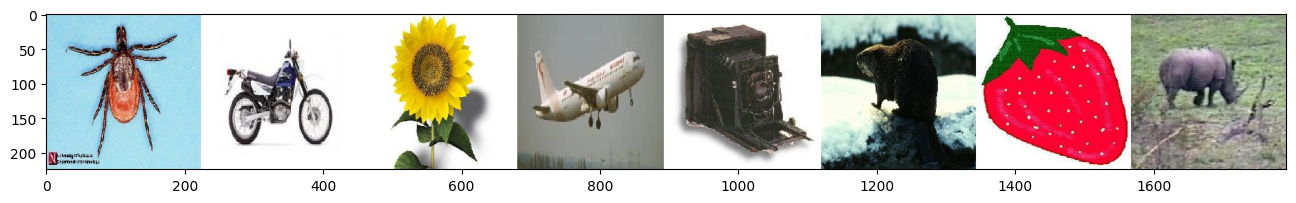

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Carregando Rede VGG16 do Keras
treinada par ao ImageNet

estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.
Carregando Rede VGG16 do Keras
treinada par ao ImageNet
Assim que a rede for carregada, podemos inspecionar novamente as camadas com o summary()método.

In [14]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

 VGG16 contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

 O VGG16 foi criado para resolver o ImageNet e atinge uma taxa de erro top-5 de 8,8% , o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão top-1 — equivalente à métrica de precisão que temos usado (que a previsão top está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a segunda camada até a última, e então trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a Modelclasse keras para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está na verdade apenas copiando todas as camadas por referência, e assim não precisamos nos preocupar em sobrecarregar a memória.

In [15]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente essa rede, `model_new`no novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o trainablesinalizador em cada camada como falso (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino demais com esse conjunto de dados possa causar overfit. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então, vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para fins de comparação justa. Então, rodamos summarynovamente para olhar a arquitetura da rede.

In [16]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,657,953 (513.68 MB)

 Trainable params: 397,409 (1.52 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, junto com o mesmo algoritmo de otimização. Também mantemos o controle do histórico dele conforme avançamos.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Nossa precisão de validação fica próxima de 80% no final, o que representa uma melhoria de mais de 30% na rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que essa rede na verdade treina um pouco mais rápido que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque congelar os pesos nega a necessidade de retropropagar por todas essas camadas, economizando tempo de execução.

Vamos traçar novamente a perda de validação e a precisão, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a sobreajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais abandono, mas certamente não teríamos compensado a melhoria de >30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])

### Melhorando os resultados
78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista muito boa. Não é tão impressionante quanto o VGG16 original, que atingiu 73% de precisão top-1 em 1000 classes. No entanto, é muito melhor do que o que conseguimos atingir com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

- Uso de aumento de dados: aumento se refere ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc. para aumentar o tamanho do conjunto de treinamento e criar mais tolerância para tais distorções.
- Usando um otimizador diferente, adicionando mais regularização/eliminação e outros hiperparâmetros.
Treinar por mais tempo (claro)

Um exemplo mais avançado de aprendizagem de transferência no Keras, envolvendo aumento para um pequeno conjunto de dados de 2 classes, pode ser encontrado no blog do Keras [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).